In [1]:
import numpy as np
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from sklearn.preprocessing import StandardScaler
import pandas as pd

from utils import *

In [2]:
device = torch.device('cuda:0')

In [3]:
result_dir = '../results/ids-dataset'
batch_size = 256

In [4]:
Xtr_, ytr, Xte_,yte,st_scaler_bn = load_cicids_data(dataname="2017",prob_type="binary",
                                                  result_dir = result_dir, return_scaler =True)

In [5]:
Xtr = st_scaler_bn.transform(Xtr_)
Xte = st_scaler_bn.transform(Xte_)
train_bnloader = make_dataloader(Xtr,ytr, batch_size = batch_size, shuffle=True)
test_bnloader = make_dataloader(Xte,yte, batch_size = batch_size, shuffle=False)

In [6]:
Xtrm_, ytrm, Xtem_,ytem,st_scaler_mul = load_cicids_data(dataname="2017",prob_type="mult",
                                                         result_dir = result_dir, return_scaler =True)

{'Web Attack \x96 Brute Force': 0, 'Web Attack \x96 XSS': 0, 'Web Attack \x96 Sql Injection': 0, 'DDoS': 1, 'Bot': 2, 'DoS slowloris': 3, 'DoS Slowhttptest': 4, 'DoS Hulk': 5, 'DoS GoldenEye': 6, 'PortScan': 7, 'FTP-Patator': 8, 'SSH-Patator': 9}
drop Benign
drop Infiltration
drop Heartbleed
original instances:  1040360
drop intances:  751106
after drop:  289254
drop Benign
drop Infiltration
drop Heartbleed
original instances:  260090
drop intances:  187670
after drop:  72420


In [7]:
Xtrm = st_scaler_mul.transform(Xtrm_)
Xtem = st_scaler_mul.transform(Xtem_)
train_mulloader = make_dataloader(Xtrm,ytrm.to_numpy().flatten(), batch_size = batch_size, shuffle=True)
test_mulloader = make_dataloader(Xtem,ytem.to_numpy().flatten(), batch_size = batch_size, shuffle=False)

## 수정 필요! scaling 을 multi-classification 에 맞추어야 함!

In [8]:
Xbtr = st_scaler_mul.transform(Xtr_[ytr==0])
Xbte = st_scaler_mul.transform(Xte_[yte==0])
outlier_trloader = make_dataloader(Xbtr,np.zeros(len(Xbtr)),batch_size=batch_size, shuffle=True)
outlier_teloader = make_dataloader(Xbte,np.zeros(len(Xbte)),batch_size=batch_size, shuffle=True)

In [9]:
lab_dic, lab_name = cluster_labels_2017()

{'Web Attack \x96 Brute Force': 0, 'Web Attack \x96 XSS': 0, 'Web Attack \x96 Sql Injection': 0, 'DDoS': 1, 'Bot': 2, 'DoS slowloris': 3, 'DoS Slowhttptest': 4, 'DoS Hulk': 5, 'DoS GoldenEye': 6, 'PortScan': 7, 'FTP-Patator': 8, 'SSH-Patator': 9}


# binary classification

In [13]:
n_features = Xtr.shape[1]
clf_bn = BinaryNN(n_features)

In [12]:
epochs = 30
criterion_bn = nn.BCELoss()
optim_bn = optim.Adam(clf_bn.parameters(),lr=0.0001)

In [19]:
clf_bn.load_state_dict(torch.load(os.path.join(result_dir, "cicids17_bn_clf.pth"),map_location='cpu'))
# clf_bn = train_model(clf_bn, train_bnloader, optim_bn, device, criterion_bn, epochs, save_dir = result_dir, 
#                      save_model = "cicids17_bn_clf.pth",binary=True)

<All keys matched successfully>

In [18]:
# torch.save(clf_mul,os.path.join(result_dir, "cicids17_bn_clf.pth"))
test_model(clf_bn, test_bnloader, criterion, device, 100.0, binary=True)

(tensor(0.0304), tensor(0.9927), tensor(0.0047))

In [26]:
from sklearn.metrics import roc_curve, auc

predy = get_prediction(clf_bn, test_bnloader, device)
testy = test_bnloader.dataset.tensors[1]
pos_label = 1 # 1 or 0
fpr, tpr, thresholds = roc_curve(testy.numpy(), predy.numpy(), pos_label=pos_label)
roc_auc = auc(fpr, tpr)

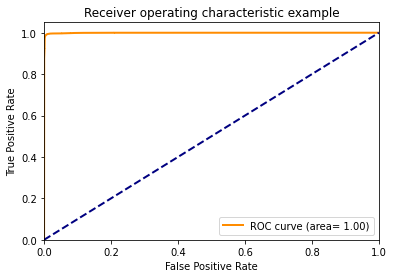

In [27]:
import matplotlib.pyplot as plt

lw=2
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=lw, label ="ROC curve (area= %.2f)"%roc_auc)
plt.plot([0,1],[0,1], color = "navy", lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

# multi-class classification

In [10]:
num_class = len(np.unique(ytrm))
n_features = Xtrm.shape[1]

In [11]:
clf_mul = MultNN(n_features, n_hidden=32, num_class=num_class)

In [12]:
epochs = 30
criterion_mul = nn.CrossEntropyLoss()
criterion_oe = nn.KLDivLoss()
optim_mul = optim.Adam(clf_mul.parameters(),lr=0.0001)

In [13]:
clf_mul = train_model_with_oe_KL(clf_mul, train_mulloader, outlier_trloader, num_class, optim_mul, device, 
                                 criterion_mul, criterion_oe, 1.0,epochs, save_dir = result_dir, 
                     save_model = "cicids17_mul_clf_OE.pth",binary=False)

/home/saerom/.pyenv/versions/pytorch111/lib/python3.8/site-packages/torch/nn/functional.py:2747: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(



Epoch [1/30]	Loss 0.9866 (0.6132)	Loss1/Loss2 0.9486/0.0381	Prec@1 train 80.027 (21.819)   	

Epoch [2/30]	Loss 0.2773 (0.0602)	Loss1/Loss2 0.2346/0.0428	Prec@1 train 94.612 (1.935)   	

Epoch [3/30]	Loss 0.1686 (0.0362)	Loss1/Loss2 0.1309/0.0377	Prec@1 train 97.862 (1.088)   	

Epoch [4/30]	Loss 0.1228 (0.0288)	Loss1/Loss2 0.0889/0.0338	Prec@1 train 98.575 (0.743)   	

Epoch [5/30]	Loss 0.0993 (0.0204)	Loss1/Loss2 0.0686/0.0307	Prec@1 train 98.761 (0.686)   	

Epoch [6/30]	Loss 0.0854 (0.0181)	Loss1/Loss2 0.0569/0.0285	Prec@1 train 98.953 (0.618)   	

Epoch [7/30]	Loss 0.0756 (0.0169)	Loss1/Loss2 0.0493/0.0263	Prec@1 train 99.116 (0.590)   	

Epoch [8/30]	Loss 0.0684 (0.0156)	Loss1/Loss2 0.0438/0.0246	Prec@1 train 99.157 (0.539)   	

Epoch [9/30]	Loss 0.0626 (0.0146)	Loss1/Loss2 0.0396/0.0230	Prec@1 train 99.201 (0.551)   	

Epoch [10/30]	Loss 0.0578 (0.0132)	Loss1/Loss2 0.0360/0.0217	Prec@1 train 99.320 (0.477)   	

Epoch [11/30]	Loss 0.0536 (0.0125)	Loss1/Loss2 0.0331/0.0205	Prec@1

In [14]:
# clf_mul.load_state_dict(torch.load(os.path.join(result_dir, "cicids17_mul_clf_LS.pth"),map_location='cpu'))
test_model(clf_mul, test_mulloader, criterion_mul, device, 100.0, binary=False)

(tensor(0.0149), tensor(99.8232), tensor(0.2558))

# evaluate multi-class model

In [15]:
from sklearn.metrics import confusion_matrix

In [16]:
pred_m = torch.softmax(get_prediction(clf_mul, test_mulloader, device),dim=1).numpy()
predy_m = np.argmax(pred_m,axis=-1)

In [17]:
confusion_mtx = confusion_matrix(ytem, predy_m)

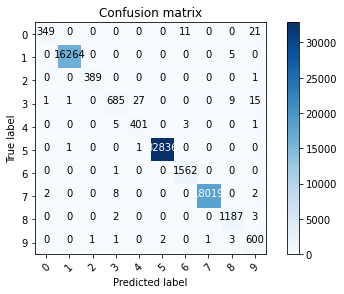

In [18]:
plot_confusion_matrix(confusion_mtx, classes = range(10))

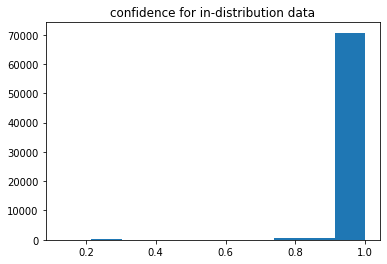

In [19]:
plt.hist(np.max(pred_m,axis=1))
plt.title("confidence for in-distribution data")
plt.show()

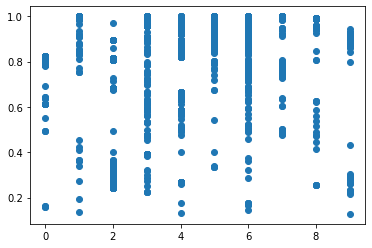

In [20]:
plt.scatter(predy_m,np.max(pred_m,axis=1))
plt.show()

In [21]:
prob_ooc = torch.softmax(get_prediction(clf_mul, outlier_trloader, device), dim=1)
pred_ooc = torch.argmax(prob_ooc, dim=1)

In [22]:
lab_dic17, lab_name17 = cluster_labels_2017()

{'Web Attack \x96 Brute Force': 0, 'Web Attack \x96 XSS': 0, 'Web Attack \x96 Sql Injection': 0, 'DDoS': 1, 'Bot': 2, 'DoS slowloris': 3, 'DoS Slowhttptest': 4, 'DoS Hulk': 5, 'DoS GoldenEye': 6, 'PortScan': 7, 'FTP-Patator': 8, 'SSH-Patator': 9}


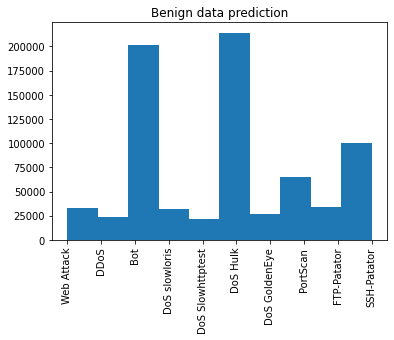

In [23]:
plt.hist(pred_ooc.numpy())
plt.title("Benign data prediction")
plt.xticks(range(10),lab_name17, rotation=90)
plt.show()

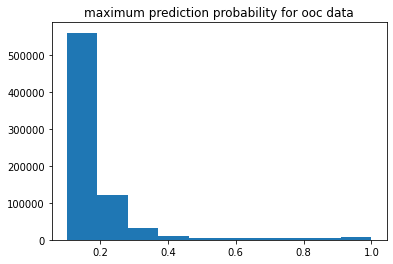

In [24]:
plt.hist(np.max(prob_ooc.numpy(),axis=1))
plt.title("maximum prediction probability for ooc data")
plt.show()

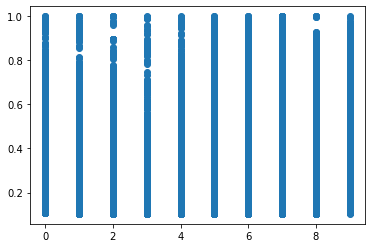

In [25]:
plt.scatter(pred_ooc,np.max(prob_ooc.numpy(),axis=1),)
plt.show()